In [59]:
import pickle
from data.pdb_utils import VOCAB
import torch
from torch_scatter import scatter_mean, scatter_sum
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import lmdb
from atom3d.datasets import LMDBDataset

from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

import prolif
from prolif.plotting.network import LigNetwork

# Specify Your Binding Complex of Interest & Number of Edge to Visualize & Paths

In [60]:
data_id = '1c86'
num_edge = 10

LMDB_path = 'datasets/LBA/split-by-sequence-identity-30/data/test'
# processed_data_path = 'datasets/LBA/split-by-sequence-identity-30/data/test.LBADatasetPS_300_processed.pkl'
processed_data_path = 'datasets/LBA/split-by-sequence-identity-30/data/test.LBADataset_processed.pkl'
Shapley_value_path = 'output/1c86/1c86_statistics.txt'

# Load Raw Data

In [61]:
lmdb_dataset = LMDBDataset(LMDB_path)
raw_data_item = lmdb_dataset.__getitem__(lmdb_dataset.ids().index(data_id))

# Get Residue Index

In [62]:
residue_id = raw_data_item['atoms_pocket'][['residue', 'resname']].drop_duplicates().reset_index(drop=True)

# Generate RDKit.Mol Object of Ligand

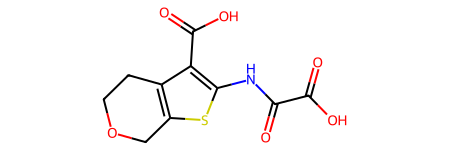

In [63]:
raw_bond_df = raw_data_item["bonds"]
raw_atom_df = raw_data_item["atoms_ligand"]

# iterate through raw_atom_df to add atoms to the molecule, then iterate through raw_bond_df to add bonds
rwmol = Chem.RWMol()

for i, atom in raw_atom_df.iterrows():
    atom = Chem.Atom(atom['element'])
    rwmol.AddAtom(atom)
    
for i, bond in raw_bond_df.iterrows():
    if bond['type'] == 1:
        bond_type = Chem.BondType.SINGLE
    elif bond['type'] == 2:
        bond_type = Chem.BondType.DOUBLE
    elif bond['type'] == 3:
        bond_type = Chem.BondType.TRIPLE
    else:
        raise ValueError(f"Unknown bond type {bond['type']}")
    rwmol.AddBond(int(bond['atom1']), int(bond['atom2']), bond_type)
    
# convert RWMol to Mol
ligand_mol = rwmol.GetMol()
ligand_mol

# Load Processed Data

In [64]:
# load data
with open(processed_data_path, 'rb') as f:
    data = pickle.load(f)

# get index and batch (binding complex) of interest
idx = [i for i, d in enumerate(data[1]) if d['id'] == data_id][0]
batch = data[2][idx]

In [65]:
# get useful data from batch
Z = torch.tensor(batch['X'])
B = torch.tensor(batch['B'])
A = torch.tensor(batch['A'])

block_lengths = torch.tensor(batch['block_lengths'])
Z = Z.reshape(Z.shape[0], 1, Z.shape[1])

In [66]:
# get coords of each amino acid and ligand atoms
with torch.no_grad():
    block_id = torch.zeros_like(A) # [Nu]
    block_id[torch.cumsum(block_lengths, dim=0)[:-1]] = 1
    block_id.cumsum_(dim=0)  # [Nu], block (residue) id of each unit (atom)
    
    assert Z.shape[1] == 1, "n_channel must be 1"
    top_Z = scatter_mean(Z, block_id, dim=0)  # [Nb, n_channel, 3]
B_coords = top_Z.reshape(top_Z.shape[0], top_Z.shape[2])

# coords of each amino acid and ligand atoms
B_coords.shape

torch.Size([29, 3])

In [48]:
# convert indexed data to name of amino acid and ligand atoms
B_abrv = [VOCAB.idx_to_abrv(i) for i in B]
# replace <G> with Global
B_abrv = ['Global' if abrv == '<G>' else abrv for abrv in B_abrv]
B_abrv
# find the start index of first single letter string in list (which is the start of ligand in the list)
ligand_start_idx = next(i for i, abrv in enumerate(B_abrv) if len(abrv) == 1)
ligand_start_idx

24

In [49]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand

# Load Shapley Value

In [50]:
with open(Shapley_value_path, 'r') as f:
    lines = f.readlines()
    shapley_dict = {}
    for line in lines[8:]:
        node_idx1 = int(line.split(',')[0].split('(')[1])
        node_idx2 = int(line.split(',')[1].split(')')[0])
        shapley_val = float(line.split(':')[-1])
        shapley_dict[(node_idx1, node_idx2)] = shapley_val

# descending sort the shapley_dict based on shapley_val
shapley_dict = dict(sorted(shapley_dict.items(), key=lambda item: item[1], reverse=True))

In [51]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand
# 
# filter only edge where node1 is amino acid and node2 is ligand atoms or vice versa
shapley_dict_bridge_edge = {k: v for k, v in shapley_dict.items() if (k[0] in range(1, ligand_start_idx-1) and k[1] in range(ligand_start_idx, len(B_abrv)+1)) or (k[0] in range(ligand_start_idx, len(B_abrv)+1) and k[1] in range(1, ligand_start_idx-1))}

# Min-Max normalize shapley_dict_bridge_edge from 0 to 1
shapley_dict_bridge_edge_normalized = {k: (v - min(shapley_dict_bridge_edge.values()))/(max(shapley_dict_bridge_edge.values())-min(shapley_dict_bridge_edge.values())) for k, v in shapley_dict_bridge_edge.items()}

In [52]:
# get top edges with highest shapley value
top_edges = list(shapley_dict_bridge_edge.keys())[:num_edge]
top_edges_shapley = list(shapley_dict_bridge_edge.values())[:num_edge]

# reorder each edge in top_edges, where small index is node1 and large index is node2
top_edges = [edge if edge[0] < edge[1] else (edge[1], edge[0]) for edge in top_edges]
top_edges, top_edges_shapley, B_coords.shape, len(top_edges)

([(6, 33),
  (8, 34),
  (5, 33),
  (7, 35),
  (11, 35),
  (4, 32),
  (1, 31),
  (5, 31),
  (14, 29),
  (12, 34)],
 [0.09202649593353271,
  0.0633277177810669,
  0.05033116340637207,
  0.049698808789253236,
  0.04567122459411621,
  0.04484680593013764,
  0.044182753562927245,
  0.04098138511180878,
  0.04018935561180115,
  0.040009573101997375],
 torch.Size([42, 3]),
 10)

# Visualize Using prolif

In [53]:
# a function to calculate distance between two atoms
def calc_distance(node1, node2):
    # just use euclidean distance
    return np.linalg.norm(B_coords[node1] - B_coords[node2])

In [54]:
# construct dataframe for prolif
df = pd.DataFrame(columns=["ligand", "protein", "interaction", "atoms", "weight", "distance"])

# iterate through top_20_edges. for each edge, store ligand as 1c86; then map node1 to VOCAB, store as protein; store node2 as atoms; store shapley value as weight; then using calc_distance to calculate distance, and store distance 
for i, edge in enumerate(top_edges):
    if edge[0] == 23:
        continue
    ligand = "1c86"
    # idx here is the idx in the B, use B[idx] to map back to amino acid or atom number
    protein = VOCAB.idx_to_abrv(B[edge[0]]) + str(residue_id.iloc[edge[0]-1]['residue'])
    atom_idx = int(edge[1]-24)
    # create a tuple with only 1 element
    atoms = (atom_idx,)
    interaction = "Shapley Value"
    weight = top_edges_shapley[i] * 30
    distance = calc_distance(edge[0], edge[1])
    df = pd.concat([df, pd.DataFrame({"ligand": ligand, "protein": protein, "interaction": interaction, "atoms": atoms, "weight": weight, "distance": distance})], ignore_index=True)

# set atoms type to tuple
df.atoms = df.atoms.apply(lambda x: (x,))

# order by protein, interaction, atoms
df.sort_values(by=["ligand", "protein", "interaction", "atoms"], inplace=True)
df.set_index(["ligand", "protein", "interaction", "atoms"], inplace=True)
df

/tmp/ipykernel_241634/1703554798.py:17: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



weight   distance
ligand protein interaction   atoms                     
1c86   ARG45   Shapley Value (7,)   1.325483   8.927657
       ASN111  Shapley Value (9,)   2.760795   9.963272
       GLU115  Shapley Value (11,)  1.490964   7.801955
       GLY183  Shapley Value (10,)  1.200287  10.298582
       LEU110  Shapley Value (7,)   1.229442  11.374101
                             (9,)   1.509935  12.100582
       LYS120  Shapley Value (10,)  1.899832   5.078326
       PHE182  Shapley Value (11,)  1.370137   6.081975
       SER216  Shapley Value (5,)   1.205681   8.604921
       VAL49   Shapley Value (8,)   1.345404   8.030542

# If edges clustered together, run the below code block again to generate another plot

# Please Ignore the Hydrophobic in the bottom left, this is WRONG information 

In [58]:
# construct prolif network and visualize

lg = LigNetwork(df, ligand_mol)
# set color for edge
lg.COLORS['interactions']['Shapley Value'] = '#59e382'
lg.display()